In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *
import time

In [3]:
def GeneratorCity(nb_city: int = 10, size_map: tuple = (100, 100)) -> list:
    """
    Return a list of cities with random coordinates and their utility

    Arguments:
        nb_city: Number of cities
        size_map: Area of the map in this format : (max_abscissa, max_ordinate)
        display: Draw a diagram of the situation

    Return:
        An array of cities with the abscissa, ordinate and the use of each cities ;
        0 means "This city is not important" ;
        1 means "This city must be delivered" ;
        2 means "This city is the depository" ;
    """

    # Randomization of points
    abscissa = random.sample(range(0, size_map[0]), nb_city)
    ordinate = random.sample(range(0, size_map[1]), nb_city)

    # Return the list of coordinate
    return [[abscissa[i],ordinate[i]] for i in range(nb_city)]


def DefinitionCity(cities: list) -> list:
    """
    Defines the type of cities

    Arguments:
        cities: The cities
        only_delivered: Removal of undelivered cities

    Return:
        The list of cities
    """

    # Define the kind of city
    delivered = random.choices(population=[0, 1], k=len(cities))

    # Define a repository
    delivered[random.randint(1, len(cities)) - 1] = 2

    # Return the list of city
    return [[cities[i][0],cities[i][1],delivered[i]] for i in range(len(cities))]


def GeneratorGraph(cities: list, fluctuation: int = 10, fluctuation_weight: int = 10):
    """
    Return the graph of the instance

    Arguments:
        cities: The coordinate from the city in this format : [max_abscissa, max_ordinate]
        fluctuation: The rate of fluctuation of the cost of the arcs
        fluctuation_weight: The fluctuation amplitude of the cost of the arcs

    Return:
        A matrix of size [nb_city, nb_city, 3]
    """

    # Initialization of the graph matrix
    generator = np.array([[(0, 0, 0)] * len(cities)] * len(cities))

    # For each element of the graph
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j:
                # Traffic randomization
                if fluctuation == 0:
                    arc_fluctuation = 0
                else:
                    arc_fluctuation = random.randrange(0, fluctuation)
                # Calculation of the distance between two points
                arc_min_cost = sqrt(pow(cities[i][0] - cities[j][0], 2) + pow(cities[i][1] - cities[j][1], 2))
                # Randomization of the traffic amplitude
                if fluctuation_weight == 0:
                    arc_fluctuation_weight = 0
                else:
                    arc_fluctuation_weight = random.randrange(0, fluctuation_weight) * arc_min_cost
                
                # Completion of the matrix
                generator[i][j] = (arc_fluctuation, arc_fluctuation_weight, arc_min_cost)

    # Return the matrix
    return generator


In [4]:
def CalculArc(graph: np.array([[()]]), time: float, arc: tuple) -> float:
    """
    Calculates the time needed to use an arc at a given time

    Arguments:
        graph: The graph
        time: The moment the arc is use
        arc: A tuple with (start node, end node)
    
    Return:
        The time used
    """

    # Recovering data from the arc
    a = graph[arc[0]-1][arc[1]-1][0]
    c = graph[arc[0]-1][arc[1]-1][1]
    d = graph[arc[0]-1][arc[1]-1][2]

    # Only if a fluctuation is present
    if a != 0 and c != 0:
        # Calculation of the interval of the function
        intervalle = 2*sqrt(c)/sqrt(a)
        # Time transposition on the function
        time = time % intervalle
        # Calculation of the cost of the arc
        return -1 * a * pow(time - sqrt(c)/sqrt(a), 2) + c + d
    
    else:
        # Return the minimum cost
        return d
    

In [61]:
def EnergieSum(graph: np.array([[()]]), cycle: tuple) -> float:
    """
    Calculation of the energies of the graph

    Arguments:
        graph: The graph

    Return:
        The energie of the graph
    
    """
    # Energy initialization
    energie = 0

    # For each point of the graph
    for i in range(len(cycle) - 1):
        # Add the energy of the path
        energie += CalculArc(graph, energie, (cycle[i], cycle[i+1]))
    
    return energie


def BasicChange(cycle: tuple):
    """
    Change the order of points

    Arguments:
        cycle: The cycle

    Return:
        The new cycle
    """

    # Index of the first element
    rand1 = random.randint(1, len(cycle) - 2)

    # Loop while there is no change
    cond = True
    while(cond):
        # Select the seconde element
        rand2 = random.randint(1, len(cycle) - 2)
        cond = rand1 == rand2

    # Format the random numbers so that rand1 is less than rand2
    if rand1>rand2 :
        rand1, rand2 = rand2, rand1

    # Return the new cycle
    return cycle[:rand1]+cycle[rand2:rand2+1]+cycle[rand1+1:rand2]+cycle[rand1:rand1+1]+cycle[rand2+1:]

def BasicChange2(cycle: tuple):
    """
    Select a segment of the cycle and either reverse it or splice it elsewhere all at random

    Arguments:
        cycle: The cycle

    Return:
        The new cycle
    """

    # Index of the first element
    rand1 = random.randint(1, len(cycle) - 2)

    # Loop to avoid rand1 == rand2
    cond = True
    while(cond):
        # Select the seconde element
        #print("test rand2")
        rand2 = random.randint(1, len(cycle) - 2)
        cond = rand1 == rand2

    # Format the random numbers so that rand1 is less than rand2
    if rand1>rand2 :
        rand1, rand2 = rand2, rand1

    # Selected segment
    segment = cycle[rand1:rand2]

    # Choose at random which change will be made
    if(random.randint(0,1)):
        # Reverse the segment
        #print("reverse")
        segment.reverse()
        return cycle[:rand1]+segment+cycle[rand2:]
    else:
        # Move the segment
        #print("move")
        reste = cycle[:rand1]+cycle[rand2:]
        # Loop to avoid rand1 == rand2
        cond = True
        while(cond):
        # Select the seconde element
            #print("test rand3")
            #print(len(reste))
            rand3 = random.randint(1, len(reste) - 1)
            #print(rand1)
            #print(rand3)
            cond = rand1 == rand3
        
        return reste[:rand3]+segment+reste[rand3:]


    

    # Return the new cycle
    return cycle[:rand1]+cycle[rand2:rand2+1]+cycle[rand1+1:rand2]+cycle[rand1:rand1+1]+cycle[rand2+1:]

def Recuit(graph: np.array([[()]]), cycle: list, energie: float, temperature: float, tempmin: float = 0.01, multipli: float = 0.99):
    """
    Find the shortest cycle using the simulated annealing algorithm

    Arguments:
        graph: The graph with the weight
        cycle: A valid path
        energie: The cost of the cycle
        temperature: The coefficient of research
        tempmin: The limit of temperature
        multipli: The modification coefficient

    Return:
        A cycle and the energie associated
    """
    
    # While the temperature is in the reseach field
    while(temperature>tempmin):
        # Create a new path
        newP = BasicChange2(cycle)
        # Calculate the cost of the new path
        newE = EnergieSum(graph, newP)

        # If the new path is bether
        if newE<energie or random.random() < exp(-(newE-energie)/temperature):
            # Change the best record
            energie = newE
            cycle = newP
        
        # Expand the field research
        temperature = temperature*multipli

    return cycle, energie

def Recuit2(graph: np.array([[()]]), cycle: list, energie: float):
    """
    Find the shortest cycle using the simulated annealing algorithm

    Arguments:
        graph: The graph with the weight
        cycle: A valid path
        energie: The cost of the cycle
        temperature: The coefficient of research
        tempmin: The limit of temperature
        multipli: The modification coefficient

    Return:
        A cycle and the energie associated
    """
    nbPoints = cycle.__len__()-2
    temperature = 20.0
    condition = True
    while(condition):
        nbChanges = 0
        for _ in range(nbPoints*100):
            # Create a new path
            newP = BasicChange2(cycle)

            # Calculate the cost of the new path
            newE = EnergieSum(graph, newP)

            # If the new path is bether
            if newE<energie :
                # Change the best record
                energie = newE
                cycle = newP
                nbChanges += 1
                if(nbChanges == 10*nbPoints):
                    break

            elif newE != energie and random.random() < exp(-(newE-energie)/temperature):
                energie = newE
                cycle = newP
        temperature *= 0.9
        condition = nbChanges != 0

    return cycle, energie
            

In [39]:
def DisplayGeneratorGraph(graph: np.array([[()]])):
    """
    Print the graph

    Arguments:
        graph: The graph
    """
    
    # For each line
    for i in range(np.shape(graph)[0]):
        # Begin with the check mark character
        print("[", end="")

        # For each column
        for j in range(np.shape(graph)[1]- 1):
            # Print the value and add a comma
            print(graph[i][j], end=", ")

        # Print the last value of the line and close it
        print(str(graph[i][j+1]) + "],")


def DisplayFigure(ax, cities: list, annotate: bool = True, red: bool = True):
    """
    Display a figure with the cities

    Arguements:
        cities: The cities
    """
    
    # Get each cities and display them
    for i in range(len(cities)):
        # Display each points
        if red or cities[i][2] != 0:
            ax.scatter(cities[i][0], cities[i][1], c= "red" if cities[i][2] == 0 else "blue" if cities[i][2] == 1 else "green")

    # Set the name of each points
    if(annotate):
        for i in range(len(cities)):
            ax.annotate(str(i+1), (cities[i][0], cities[i][1]))


def DisplayCycle(ax, cities: list, path: list, annotate: bool = True, red: bool =True):
    """
    Display a figure with the path

    Arguments:
        cities: The cities
        path: The path
    """

    # Display the cities
    DisplayFigure(ax, cities, annotate, red)
    
    # Get each arc of the path
    for i in range(len(path) - 1):
        point1 = (cities[path[i] - 1][0], cities[path[i] - 1][1])
        point2 = (cities[path[i+1] - 1][0], cities[path[i+1] - 1][1])
        # Trace the arrow
        ax.arrow(
            x = cities[path[i] - 1][0], 
            y = cities[path[i] - 1][1], 
            dx = cities[path[i+1] - 1][0] - cities[path[i] - 1][0], 
            dy = cities[path[i+1] - 1][1] - cities[path[i] - 1][1],
            head_width = 1, 
            length_includes_head=True)



In [75]:
# Seed of generation
random.seed(5)

# Generator settings
nbPoints = 1000
Size_Map = (1000, 1000)
Fluctuation = 1
Fluctuation_Weight = 1

# Generation of cities
points = DefinitionCity(GeneratorCity(nbPoints, Size_Map))

# Generation of the graph
graph = GeneratorGraph(points, Fluctuation, Fluctuation_Weight)

# Create a path with every cities which need to be delivered
cycle = []
for i in range(len(points)):
    if points[i][2] == 1:
        cycle += [i+1]
# Get the repository point
repository = [x+1 for x, y in enumerate(points) if y[2] == 2]
# Add the depository on the path
cycle = repository + cycle + repository

263160
[841, 1, 6, 8, 13, 14, 15, 17, 24, 25, 26, 27, 33, 34, 38, 40, 46, 47, 50, 52, 56, 57, 63, 64, 65, 68, 72, 78, 79, 84, 85, 87, 89, 90, 91, 92, 93, 94, 98, 102, 103, 104, 108, 109, 110, 112, 115, 118, 119, 122, 124, 126, 127, 131, 132, 134, 135, 137, 138, 142, 144, 146, 148, 149, 150, 151, 156, 157, 158, 159, 160, 161, 162, 163, 164, 169, 171, 172, 173, 176, 177, 178, 179, 180, 181, 183, 185, 187, 189, 193, 194, 195, 197, 200, 202, 203, 204, 206, 208, 210, 212, 215, 216, 219, 220, 221, 222, 223, 224, 226, 229, 231, 234, 237, 243, 245, 247, 248, 252, 253, 258, 260, 261, 262, 266, 267, 268, 270, 271, 273, 275, 277, 279, 283, 289, 293, 294, 295, 297, 299, 300, 302, 303, 307, 312, 315, 316, 321, 323, 324, 326, 327, 330, 333, 334, 336, 338, 340, 341, 342, 345, 347, 349, 351, 353, 355, 356, 357, 363, 364, 365, 366, 368, 373, 374, 377, 378, 381, 382, 383, 384, 385, 393, 395, 396, 398, 399, 402, 403, 405, 406, 409, 411, 414, 415, 418, 419, 421, 422, 423, 425, 428, 434, 438, 439, 440, 444

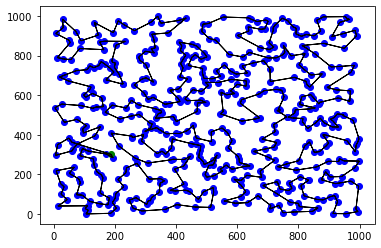

In [76]:
random.seed(time.time_ns())
#random.seed(5)
## Initiale solution
# Calculate the energie of the path
energie = EnergieSum(graph, cycle)
print(energie)
print(cycle)
# Initiate the first figure
#fig1, ax1 = plt.subplots()
#DisplayCycle(ax1, points, cycle)

## Improvement of the solution
start_time = time.time()
#cycle, energie = Recuit(graph, cycle, energie, 2000000)#, 0.001)#, 0.999)
cycle2, energie2 = Recuit2(graph, cycle, energie)

print("--- %s seconds ---" % (time.time() - start_time))
print("Time cost : %s." % energie2)
print("Cycle use : " + str(cycle2) + ".")
# Initiate the second figure
fig2, ax2 = plt.subplots()
DisplayCycle(ax2, points, cycle2, nbPoints<100, nbPoints<1000)

In [ ]:
print(random.randint(1,2))

2
